## **Import Libraries**

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier, KerasRegressor


## **Load and Preprocess the Data**

In [2]:
# Load the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
data = pd.read_excel(url)

# Handle missing values
data.dropna(subset=['CustomerID'], inplace=True)
data['TotalAmount'] = data['Quantity'] * data['UnitPrice']

# Feature engineering
customer_data = data.groupby('CustomerID').agg({
    'InvoiceDate': ['max', 'min', 'count'],
    'TotalAmount': ['sum', 'mean']
})
customer_data.columns = ['last_purchase', 'first_purchase', 'purchase_count', 'total_amount', 'avg_order_value']

# Calculate recency
customer_data['recency'] = (customer_data['last_purchase'].max() - customer_data['last_purchase']).dt.days
customer_data['lifetime_value'] = customer_data['total_amount'] # Assuming total_amount as the lifetime value

# Dropping unnecessary columns
customer_data.drop(columns=['last_purchase', 'first_purchase'], inplace=True)


## **Prepare Features and Target Variable**

In [3]:
# Features and target
X = customer_data.drop(columns=['lifetime_value'])
y = customer_data['lifetime_value']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## **Define the Preprocessing Pipeline**

In [4]:
# Preprocessing pipeline
numeric_features = ['purchase_count', 'total_amount', 'avg_order_value', 'recency']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Ensure X_train and X_test are DataFrames with the appropriate column names
X_train_df = pd.DataFrame(X_train, columns=numeric_features)
X_test_df = pd.DataFrame(X_test, columns=numeric_features)

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train_df)
X_test_processed = preprocessor.transform(X_test_df)


## **Define Models and Hyperparameter Tuning**

### **Linear Regression**

In [5]:
# Linear Regression
lin_reg = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', LinearRegression())])

lin_reg.fit(X_train_df, y_train)
y_pred_lin = lin_reg.predict(X_test_df)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
print("Linear Regression RMSE:", rmse_lin)


Linear Regression RMSE: 2.2123507485565384e-11


### **Random Forest**

In [6]:
# Random Forest
rf_reg = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', RandomForestRegressor(random_state=42))])

param_grid_rf = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [10, 20]
}

rf_search = GridSearchCV(rf_reg, param_grid_rf, cv=5, scoring='neg_mean_squared_error')
rf_search.fit(X_train_df, y_train)
print("Best parameters for Random Forest:", rf_search.best_params_)
y_pred_rf = rf_search.predict(X_test_df)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("Random Forest RMSE:", rmse_rf)


Best parameters for Random Forest: {'regressor__max_depth': 20, 'regressor__n_estimators': 100}
Random Forest RMSE: 812.4392570770107


### **Gradient Boosting**

In [7]:
# Gradient Boosting
gb_reg = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', GradientBoostingRegressor(random_state=42))])

param_grid_gb = {
    'regressor__n_estimators': [50, 100],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__max_depth': [3, 5]
}

gb_search = GridSearchCV(gb_reg, param_grid_gb, cv=5, scoring='neg_mean_squared_error')
gb_search.fit(X_train_df, y_train)
print("Best parameters for Gradient Boosting:", gb_search.best_params_)
y_pred_gb = gb_search.predict(X_test_df)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
print("Gradient Boosting RMSE:", rmse_gb)


Best parameters for Gradient Boosting: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 50}
Gradient Boosting RMSE: 2038.2242858356744


### **Neural Network**

In [10]:
# Neural Network
def create_nn_model(learning_rate=0.01):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=X_train_processed.shape[1]))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_squared_error')
    return model

# Create a KerasRegressor
def create_keras_regressor(learning_rate=0.01):
    return KerasRegressor(build_fn=create_nn_model, learning_rate=learning_rate, verbose=0)

# Define parameter grid
param_grid_nn = {
    'build_fn': [lambda: create_nn_model(learning_rate=0.01), lambda: create_nn_model(learning_rate=0.001)],
    'epochs': [50, 100],
    'batch_size': [10, 20]
}

# Create KerasRegressor instance
nn_reg = KerasRegressor(build_fn=create_nn_model, verbose=0)

# Perform GridSearchCV
nn_search = GridSearchCV(nn_reg, param_grid_nn, cv=5, scoring='neg_mean_squared_error')
nn_search.fit(X_train_processed, y_train)

# Best parameters and evaluation
print("Best parameters for Neural Network:", nn_search.best_params_)
y_pred_nn = nn_search.predict(X_test_processed)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
print("Neural Network RMSE:", rmse_nn)


/home/deep123/anaconda3/envs/py31/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/deep123/anaconda3/envs/py31/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-07-31 21:25:18.143269: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-31 21:25:18.355786: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devi

Best parameters for Neural Network: {'batch_size': 10, 'build_fn': <function <lambda> at 0x7ff55b8f54e0>, 'epochs': 100}
Neural Network RMSE: 26.191113265516258


## **Plotting Predicted vs. Actual Values**

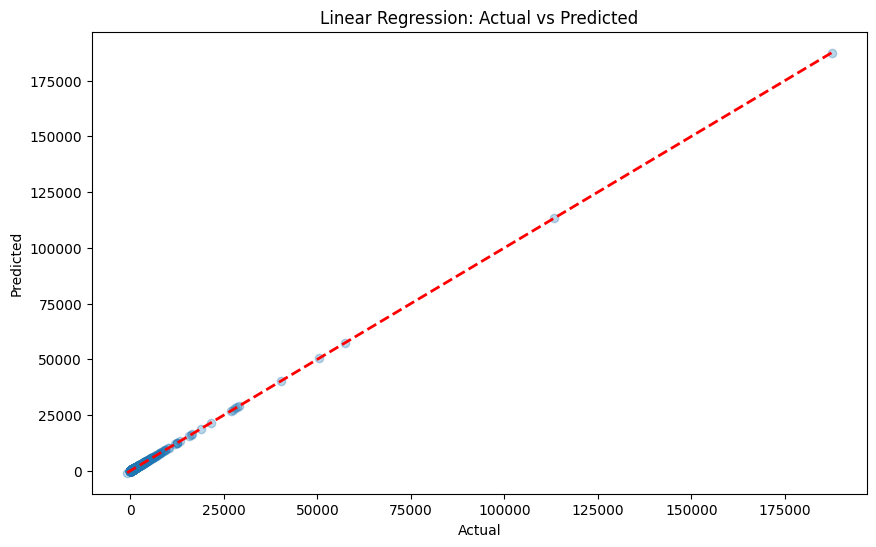

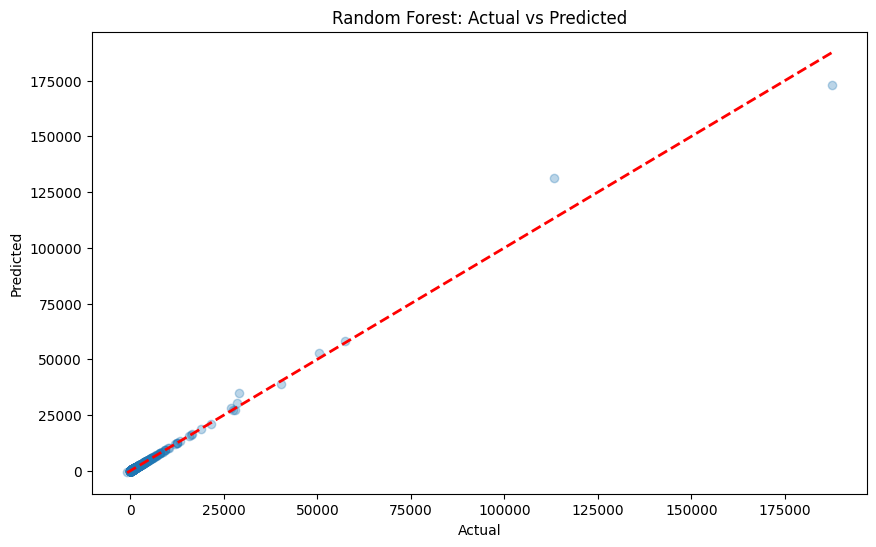

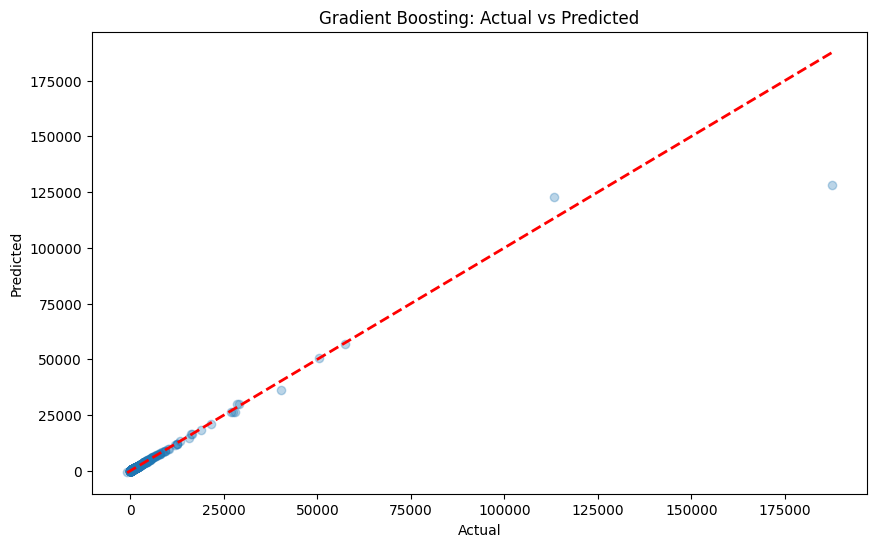

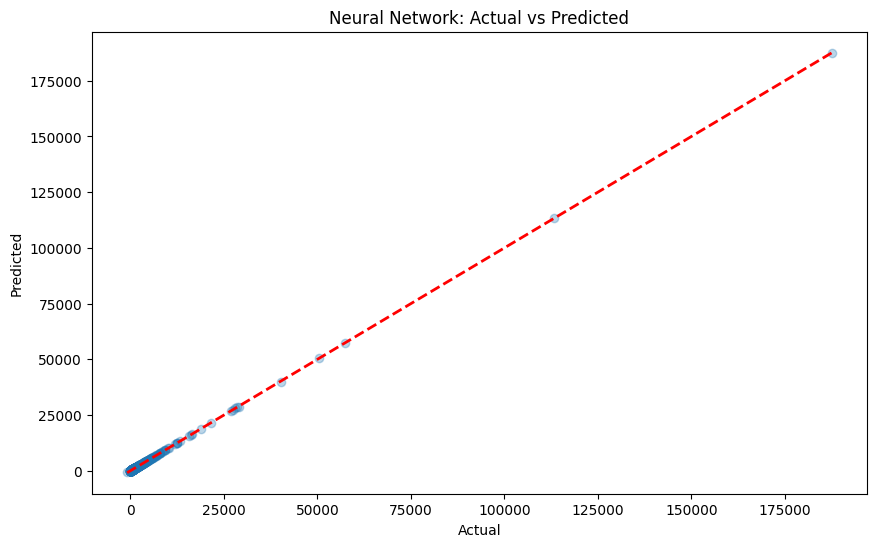

In [14]:
# Function to plot predictions
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r', linewidth=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.show()

# Plot for Linear Regression
plot_predictions(y_test, y_pred_lin, 'Linear Regression: Actual vs Predicted')

# Plot for Random Forest
plot_predictions(y_test, y_pred_rf, 'Random Forest: Actual vs Predicted')

# Plot for Gradient Boosting
plot_predictions(y_test, y_pred_gb, 'Gradient Boosting: Actual vs Predicted')

# Plot for Neural Network
plot_predictions(y_test, y_pred_nn, 'Neural Network: Actual vs Predicted')

## **Summary of Results**

In [15]:
# Summary of results
results = {
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Neural Network'],
    'RMSE': [rmse_lin, rmse_rf, rmse_gb, rmse_nn]
}

results_df = pd.DataFrame(results)
print(results_df)

               Model          RMSE
0  Linear Regression  2.212351e-11
1      Random Forest  8.124393e+02
2  Gradient Boosting  2.038224e+03
3     Neural Network  2.619111e+01


## **Feature Importance Analysis**

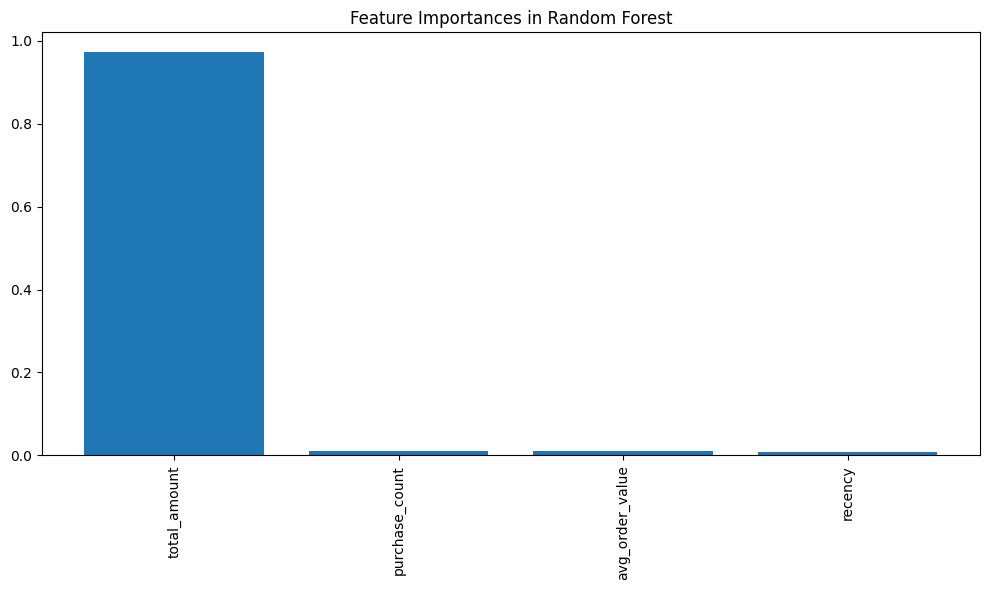

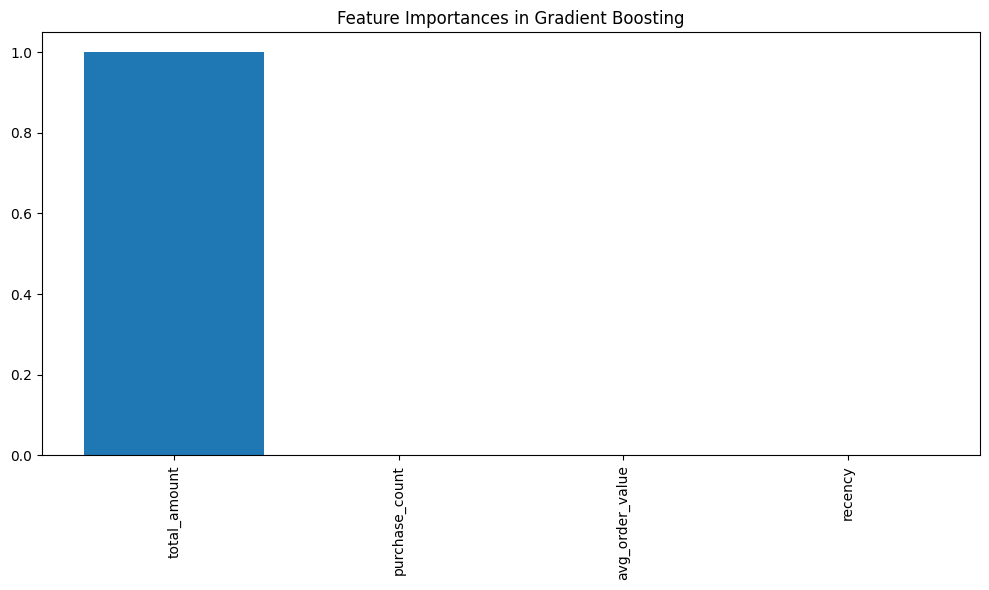

In [16]:
# Feature importance for Random Forest
rf_best_model = rf_search.best_estimator_.named_steps['regressor']
importances_rf = rf_best_model.feature_importances_

# Feature importance for Gradient Boosting
gb_best_model = gb_search.best_estimator_.named_steps['regressor']
importances_gb = gb_best_model.feature_importances_

# Plot feature importance
def plot_feature_importance(importances, model_name, feature_names):
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances in {model_name}")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

feature_names = numeric_features

plot_feature_importance(importances_rf, "Random Forest", feature_names)
plot_feature_importance(importances_gb, "Gradient Boosting", feature_names)


## **Model Interpretation using SHAP Values**

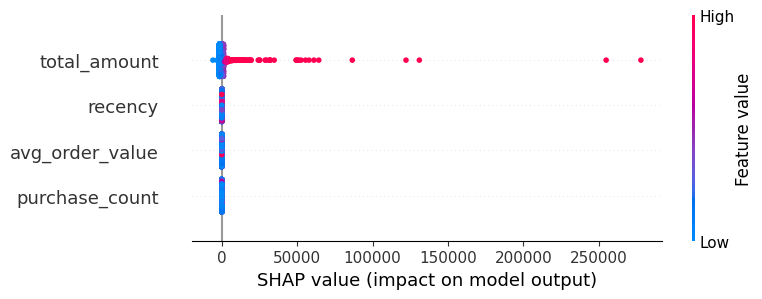

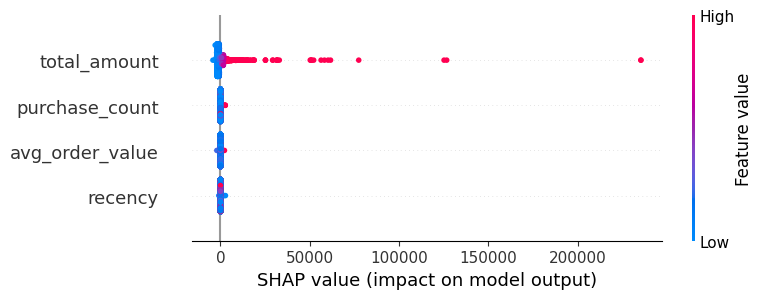

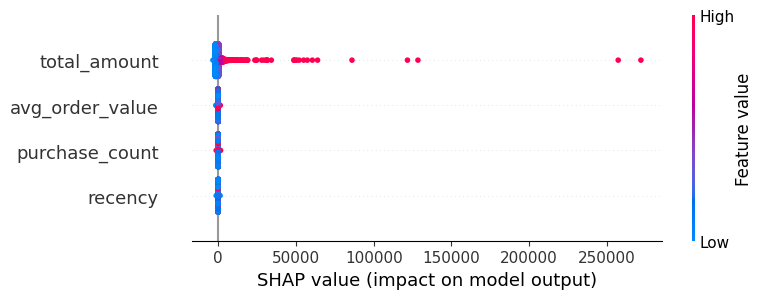

  0%|          | 0/100 [00:00<?, ?it/s]

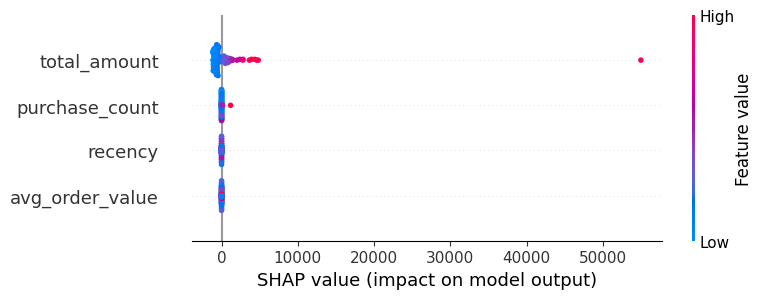

In [21]:
import shap

# Function to create SHAP plots
def shap_summary_plot(model, X, model_name, model_type='tree'):
    if model_type == 'tree':
        explainer = shap.TreeExplainer(model)
        shap_values = explainer(X, check_additivity=False)
    else:
        explainer = shap.Explainer(model, X)
        shap_values = explainer(X)
    shap.summary_plot(shap_values, X, feature_names=feature_names, title=f"SHAP Summary Plot for {model_name}")

# Linear Regression
lin_reg_model = lin_reg.named_steps['regressor']
shap_summary_plot(lin_reg_model, X_train_processed, "Linear Regression", model_type='linear')

# Random Forest
shap_summary_plot(rf_best_model, X_train_processed, "Random Forest", model_type='tree')

# Gradient Boosting
shap_summary_plot(gb_best_model, X_train_processed, "Gradient Boosting", model_type='tree')

# Neural Network
def nn_predict(X):
    return nn_search.best_estimator_.predict(X)

nn_explainer = shap.KernelExplainer(nn_predict, X_train_processed[:100])  # Using a subset for speed
shap_values_nn = nn_explainer.shap_values(X_test_processed[:100])
shap.summary_plot(shap_values_nn, X_test_processed[:100], feature_names=feature_names, title="SHAP Summary Plot for Neural Network")
